## Overview

In [1]:
BATCH_SIZE = 4
import os
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import _montage as montage
import cv2
import random
from datetime import datetime
import json
import gc

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn
import torch.backends.cudnn
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose



from tqdm import tqdm
from pathlib import Path

from skimage.morphology import label

In [2]:
PATH = 'F:/[Base] Code/DataSets/airbus-ship-detection'
print(os.listdir(PATH))

['sample_submission_v2.csv', 'test_v2', 'train_ship_segmentations_v2.csv', 'train_v2']


In [3]:
train_image_dir = PATH + '/train_v2'
test_image_dir = PATH + '/test_v2'
train_image_dir

'F:/[Base] Code/DataSets/airbus-ship-detection/train_v2'

In [4]:
# run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def multi_rle_encode(img):
    labels = label(img)
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def mask_overlay(image, mask, color=(0, 1, 0)):
    """
    Helper function to visualize mask on the top of the image
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]    
    return img

def imshow(img, mask, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    fig = plt.figure(figsize = (6,6))
    plt.imshow(mask_overlay(img, mask))
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [5]:
masks = pd.read_csv(PATH + '/train_ship_segmentations_v2.csv')
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], 'unique images found')
masks.head()

231723 masks found
192556 unique images found


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


## Undersample Empty Images
we choose to randomly drop the empty images to get a better balanced group with more ships to train

In [6]:
print(masks.shape[0])
masks = masks.drop(masks[masks.EncodedPixels.isnull()].sample(150000,random_state=42).index)
print(masks.shape[0])
masks.sample(3)

231723
81723


,ImageId,EncodedPixels
89782,6316528fb.jpg,364941 2 365706 5 366472 8 367237 11 368002 14...
95528,695359ae6.jpg,525455 1 526222 4 526990 5 527757 7 528525 6 5...
35948,27cb9459c.jpg,55475 2 56243 4 57010 7 57778 9 58545 10 59313...


## Split Datasets
we choose to split original dataset into training sets and validation sets to vanish the bias<br>
split rate — 19 : 1

In [7]:
from sklearn.model_selection import train_test_split
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.05, 
                 stratify = unique_img_ids['counts'],
                 random_state=42
                )
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')
train_df.head(3)

77636 training masks
4087 validation masks


,ImageId,EncodedPixels,counts
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
2,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,5


In [8]:
train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if isinstance(
    c_row['EncodedPixels'], str
) else 0, 1)
valid_df['counts'] = valid_df.apply(lambda c_row: c_row['counts'] if isinstance(
    c_row['EncodedPixels'], str
) else 0, 1)
print(type(train_df))

<class 'pandas.core.frame.DataFrame'>


In [9]:
train_df.drop(train_df.index[0: 77000], inplace=True)
valid_df.drop(valid_df.index[0: 4000], inplace=True)

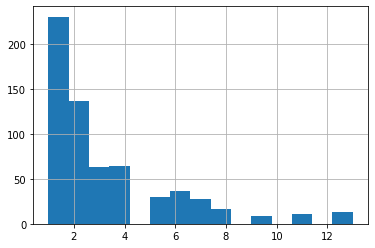

In [10]:
train_df['counts'].hist(bins = 15)

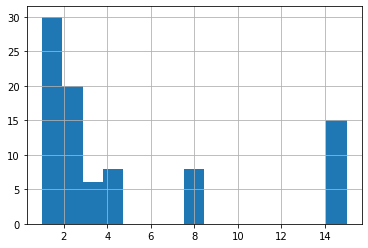

In [11]:
valid_df['counts'].hist(bins = 15)

In [12]:
print(train_df.ImageId.nunique(), 'unique images in train set')
print(valid_df.ImageId.nunique(),'unique images in test set')

356 unique images in train set
46 unique images in test set


## Dataset class using PyThorch dataloader

In [13]:
class ShipDataset(Dataset):
    def __init__(self, in_df, transform=None, mode='train'):
        grp = list(in_df.groupby('ImageId'))
        self.image_ids =  [_id for _id, _ in grp] 
        self.image_masks = [m['EncodedPixels'].values for _,m in grp]
        self.transform = transform
        self.mode = mode
        self.img_transform = Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_ids)
               
    def __getitem__(self, idx):
        img_file_name = self.image_ids[idx]
        if self.mode == 'train':
            rgb_path = os.path.join(train_image_dir, img_file_name)
        else:
            rgb_path = os.path.join(test_image_dir, img_file_name)
        img = imread(rgb_path)
        mask = masks_as_image(self.image_masks[idx])
       
        if self.transform is not None:
            img, mask = self.transform(img, mask)

        if self.mode == 'train':
            #return self.to_float_tensor(img), self.to_float_tensor(mask)
            #eturn img, mask
            return self.img_transform(img), torch.from_numpy(np.moveaxis(mask, -1, 0)).float()
        else:
            return self.img_transform(img), str(img_file_name)

---
## Check for datasets

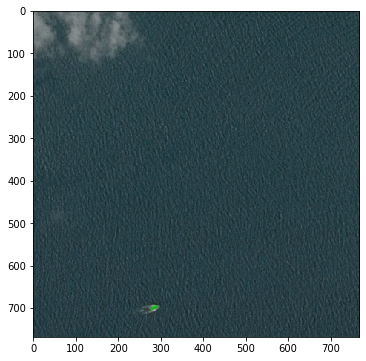

In [14]:
#Create dataset
dataset_valid = ShipDataset(valid_df)
#To show image with its mask
# dataset_valid.__getitem__(0)
imshow(*dataset_valid[0])

## U-net Model

In [15]:
class UNet_down_block(torch.nn.Module):
    def __init__(self, input_channel, output_channel, down_size):
        super(UNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

class UNet_up_block(torch.nn.Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super(UNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_block1 = UNet_down_block(3, 16, False)
        self.down_block2 = UNet_down_block(16, 32, True)
        self.down_block3 = UNet_down_block(32, 64, True)
        self.down_block4 = UNet_down_block(64, 128, True)
        self.down_block5 = UNet_down_block(128, 256, True)
        self.down_block6 = UNet_down_block(256, 512, True)
        self.down_block7 = UNet_down_block(512, 1024, True)

        self.mid_conv1 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(1024)
        self.mid_conv2 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(1024)
        self.mid_conv3 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(1024)

        self.up_block1 = UNet_up_block(512, 1024, 512)
        self.up_block2 = UNet_up_block(256, 512, 256)
        self.up_block3 = UNet_up_block(128, 256, 128)
        self.up_block4 = UNet_up_block(64, 128, 64)
        self.up_block5 = UNet_up_block(32, 64, 32)
        self.up_block6 = UNet_up_block(16, 32, 16)

        self.last_conv1 = torch.nn.Conv2d(16, 16, 3, padding=1)
        self.last_bn = torch.nn.BatchNorm2d(16)
        self.last_conv2 = torch.nn.Conv2d(16, 1, 1, padding=0)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        self.x6 = self.down_block6(self.x5)
        self.x7 = self.down_block7(self.x6)
        self.x7 = self.relu(self.bn1(self.mid_conv1(self.x7)))
        self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
        self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
        x = self.up_block1(self.x6, self.x7)
        x = self.up_block2(self.x5, x)
        x = self.up_block3(self.x4, x)
        x = self.up_block4(self.x3, x)
        x = self.up_block5(self.x2, x)
        x = self.up_block6(self.x1, x)
        x = self.relu(self.last_bn(self.last_conv1(x)))
        x = self.last_conv2(x)
        return x

## Lost Function

In [16]:
class LossBinary:
    """
     Implementation from  https://github.com/ternaus/robot-surgery-segmentation
    """

    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1.0).float()
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss

## Validation routine

In [23]:
def validation(model: nn.Module, criterion, valid_loader):
    print("Validation on hold-out....")
    model.eval()
    losses = []
    jaccard = []
    for inputs, targets in valid_loader:
        inputs = variable(inputs, volatile=True)
        targets = variable(targets)
        outputs = model(inputs)
        
        try:
            outputs = model(inputs)
        except RuntimeError as e:
            if 'out of memory' in str(e):
                print('| WARNING: ran out of memory')
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
        else:
            raise e
        
        loss = criterion(outputs, targets)
        losses.append(loss.data[0])
        jaccard += [get_jaccard(targets, (outputs > 0).float()).data[0]]

    valid_loss = np.mean(losses)  # type: float

    valid_jaccard = np.mean(jaccard)

    print('Valid loss: {:.5f}, jaccard: {:.5f}'.format(valid_loss, valid_jaccard))
    metrics = {'valid_loss': valid_loss, 'jaccard_loss': valid_jaccard}
    return metrics


def get_jaccard(y_true, y_pred):
    epsilon = 1e-15
    intersection = (y_pred * y_true).sum(dim=-2).sum(dim=-1).sum(dim = -1)
    union = y_true.sum(dim=-2).sum(dim=-1).sum(dim=-1) + y_pred.sum(dim=-2).sum(dim=-1).sum(dim = -1)

    return (intersection / (union - intersection + epsilon)).mean()

In [18]:
# sume helper functions
def variable(x, volatile=False):
    if isinstance(x, (list, tuple)):
        return [variable(y, volatile=volatile) for y in x]
    return cuda(Variable(x, volatile=volatile))

def cuda(x):
    # trap!
    return x.cuda() if torch.cuda.is_available() else x

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()

## Train

In [19]:
# main train routine
# Implementation from  https://github.com/ternaus/robot-surgery-segmentation
def train(lr, model, criterion, train_loader, valid_loader, validation, init_optimizer, n_epochs=1, fold=1):
    optimizer = init_optimizer(lr)
    #model = nn.DataParallel(model, device_ids=None)
    if torch.cuda.is_available():
        model.cuda()
    model_path = Path('model_{fold}.pt'.format(fold=fold))
    if model_path.exists():
        state = torch.load(str(model_path))
        epoch = state['epoch']
        step = state['step']
        model.load_state_dict(state['model'])
        print('Restored model, epoch {}, step {:,}'.format(epoch, step))
    else:
        epoch = 1
        step = 0

    save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))


    report_each = 50
    log = open('train_{fold}.log'.format(fold=fold),'at', encoding='utf8')
    valid_losses = []
    for epoch in range(epoch, n_epochs + 1):
        model.train()
        random.seed()
        tq = tqdm(total=len(train_loader) *  BATCH_SIZE)
        tq.set_description('Epoch {}, lr {}'.format(epoch, lr))
        losses = []
        tl = train_loader
        try:
            mean_loss = 0
            for i, (inputs, targets) in enumerate(tl):
                inputs, targets = variable(inputs), variable(targets)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                optimizer.zero_grad()
                batch_size = inputs.size(0)
                loss.backward()
                optimizer.step()
                step += 1
                tq.update(batch_size)
                losses.append(loss.data[0])
                mean_loss = np.mean(losses[-report_each:])
                tq.set_postfix(loss='{:.5f}'.format(mean_loss))
                if i and i % report_each == 0:
                    write_event(log, step, loss=mean_loss)
            write_event(log, step, loss=mean_loss)
            tq.close()
            save(epoch + 1)
            valid_metrics = validation(model, criterion, valid_loader)
            write_event(log, step, **valid_metrics)
            valid_loss = valid_metrics['valid_loss']
            valid_losses.append(valid_loss)
        except KeyboardInterrupt:
            tq.close()
            print('Ctrl+C, saving snapshot')
            save(epoch)
            print('done.')
            return

In [20]:
def make_loader(in_df, batch_size, shuffle=False, transform=None):
        return DataLoader(
            dataset=ShipDataset(in_df, transform=transform),
            shuffle=shuffle,
            num_workers = 0,
            batch_size = batch_size,
            pin_memory = torch.cuda.is_available()
        )

train_loader = make_loader(train_df, batch_size =  BATCH_SIZE, shuffle=True, transform=None)
valid_loader = make_loader(valid_df, batch_size = 1, transform=None)

In [25]:
# run just 1 epoch

#torch.cuda._initialized = True
#torch.cuda.current_device()

model = UNet()
# torch.cuda.empty_cache()
train(init_optimizer=lambda lr: Adam(model.parameters(), lr=lr),
        lr = 1e-3,
        n_epochs = 1,
        model=model,
        criterion=LossBinary(jaccard_weight=5),
        train_loader=train_loader,
        valid_loader=valid_loader,
        validation=validation,
        )


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.00 GiB already allocated; 6.26 MiB free; 13.96 MiB cached)